## IMPOSTO DE RENDA LINEAR + RENDA BÁSICA UNIVERSAL

#### OBJETIVO: Utilizar um banco de micro dados baseado na Pesquisa de Nacional por Amostra de Domicílios Contínua (PNADC) para o impacto redistributivo da substituição do atual sistema de tributos diretos e benefícios sociais por um imposto de renda linear e a introdução de uma renda básica universal.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_excel("C:\{estudos}\ESP\Economia-do-Setor-Publico-2025.2\Aplicação 4\ESP_2025_aplicação 4_PNADC 2017.xlsx")


<>:1: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\{'
C:\Users\Madu\AppData\Local\Temp\ipykernel_25196\1916804917.py:1: SyntaxWarning: invalid escape sequence '\{'
  df = pd.read_excel("C:\{estudos}\ESP\Economia-do-Setor-Publico-2025.2\Aplicação 4\ESP_2025_aplicação 4_PNADC 2017.xlsx")


In [7]:
# 1. LIMPEZA DE DADOS (Tratando #NULL! e NaNs)
cols_numericas = ['PESO', 'V2005', 'V5003A2', 'V5004A2', 'NUM_DOM', 
                  'REND_I', 'SALFAM', 'SEGDEMP', 'ABOSAL', 'ABONOA', 
                  'BPC', 'BOLSAFAM', 'CONT', 'IRPF']

for col in cols_numericas:
    # Converte para numérico, erros (#NULL!) viram NaN, depois preenche com 0
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

print("Dados carregados e limpos.")

# --- 2. CÁLCULO DO CENÁRIO BASE (STATUS QUO) ---

# Total de Transferências Atuais
df['TRANSF_TOTAL'] = df['V5003A2'] + df['V5004A2'] + df['SALFAM'] + \
                     df['SEGDEMP'] + df['ABOSAL'] + df['ABONOA'] + \
                     df['BPC'] + df['BOLSAFAM']

# Total de Tributos Atuais
df['TRIB_TOTAL'] = df['CONT'] + df['IRPF']

# Renda Domiciliar Total Atual (Soma dos indivíduos por domicílio)
# Renda Individual Disp = Mercado + Transferências - Tributos
df['REND_INDIV_DISP_ATUAL'] = df['REND_I'] + df['TRANSF_TOTAL'] - df['TRIB_TOTAL']

# Agregando por Domicílio
df['REND_DOM_TOTAL_ATUAL'] = df.groupby('CHAVE.D')['REND_INDIV_DISP_ATUAL'].transform('sum')

# Renda Domiciliar Per Capita (RDDPC)
df['RDDPC'] = df['REND_DOM_TOTAL_ATUAL'] / df['NUM_DOM']

# Definição de Pobreza Atual (Linha R$ 406)
# Considera apenas membros do domicílio (V2005 entre 1 e 16)
df['POBRE_ATUAL'] = np.where((df['RDDPC'] < 406) & (df['V2005'].between(1, 16)), 1, 0)

# Criação dos Decis Atuais (Ponderados)
def weighted_qcut(values, weights, q=10):
    df_temp = pd.DataFrame({'val': values, 'w': weights}).sort_values('val')
    df_temp['cumsum'] = df_temp['w'].cumsum()
    cutoff = df_temp['w'].sum() / q
    return pd.to_numeric(np.ceil(df_temp['cumsum'] / cutoff).clip(1, q))

df['DECIL'] = weighted_qcut(df['RDDPC'], df['PESO'])

# --- 3. SIMULAÇÃO DA REFORMA (RBU + FLAT TAX) ---

RBU_VALOR = 406.00
FLAT_RATE = 0.3570 # 35.7%

# Aposentadoria/Pensão Ajustada (V5004A2 + ABONOA + BPC - RBU)
# Se a soma for maior que RBU, mantém o excedente. Se for menor, zera (a RBU substitui).
soma_aposent = df['V5004A2'] + df['ABONOA'] + df['BPC']
df['BEN_AJU'] = np.where(soma_aposent > 0, soma_aposent - RBU_VALOR, 0)
# Correção: Se o benefício era menor que 406, o cálculo acima daria negativo.
# O correto na lógica da RBU é: Você ganha a RBU. O benefício antigo é "abatido".
# Matematicamente: Nova Renda = (Benefício - RBU) + RBU = Benefício.
# Mas na tributação: Base de Cálculo = Benefício Ajustado.

# Base de Cálculo do Novo Imposto (Renda Mercado + Benefício Ajustado)
df['BASE_CALC_NOVA'] = df['REND_I'] + df['BEN_AJU']

# Novo Imposto (Flat Tax)
df['NOVO_IRPF'] = df['BASE_CALC_NOVA'] * FLAT_RATE

# Nova Renda Individual Disponível
# Lógica: Renda Mercado + RBU + Benefício Ajustado - Novo Imposto
df['REND_INDIV_DISP_NOVA'] = df['REND_I'] + RBU_VALOR + df['BEN_AJU'] - df['NOVO_IRPF']

# Agregando por Domicílio (Novo Cenário)
df['REND_DOM_TOTAL_NOVA'] = df.groupby('CHAVE.D')['REND_INDIV_DISP_NOVA'].transform('sum')

# Nova Renda Domiciliar Per Capita
df['RDDPC_NOVA'] = df['REND_DOM_TOTAL_NOVA'] / df['NUM_DOM']

# Definição de Pobreza Nova
df['POBRE_NOVA'] = np.where((df['RDDPC_NOVA'] < 406) & (df['V2005'].between(1, 16)), 1, 0)

# Classificação Ganhador/Perdedor (Margem de segurança de R$ 0.01 para arredondamento)
df['STATUS'] = 'Neutro'
df.loc[df['RDDPC_NOVA'] > df['RDDPC'] + 0.01, 'STATUS'] = 'Ganhador'
df.loc[df['RDDPC_NOVA'] < df['RDDPC'] - 0.01, 'STATUS'] = 'Perdedor'

Dados carregados e limpos.


### GERAÇÃO DE RESULTADOS E GRÁFICOS


(i) RESULTADO: POBREZA (Linha R$ 406)
Pobres Antes:  48,699,393 (23.5%)
Pobres Depois: 0 (0.0%)
Redução de:    48,699,393 pessoas


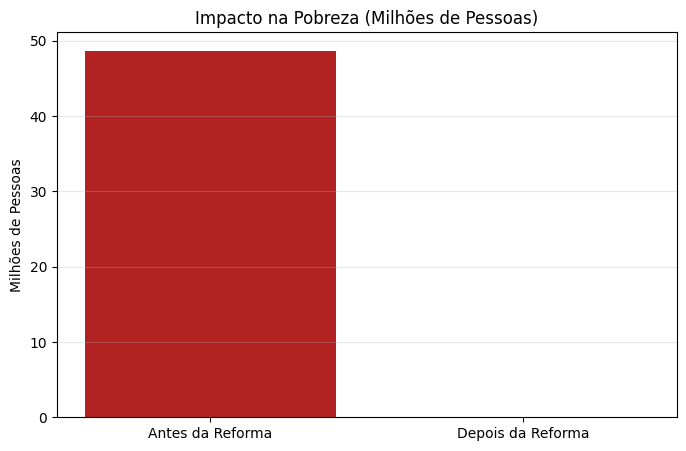

In [ ]:
# (i) Tabela de Pobreza
total_pop = df['PESO'].sum()
pobres_antes = df.loc[df['POBRE_ATUAL'] == 1, 'PESO'].sum()
pobres_depois = df.loc[df['POBRE_NOVA'] == 1, 'PESO'].sum()

print("\n" + "="*40)
print("(i) RESULTADO: POBREZA (Linha R$ 406)")
print(f"Pobres Antes:  {pobres_antes:,.0f} ({pobres_antes/total_pop:.1%})")
print(f"Pobres Depois: {pobres_depois:,.0f} ({pobres_depois/total_pop:.1%})")
print(f"Redução de:    {(pobres_antes - pobres_depois):,.0f} pessoas")
print("="*40)

# Gráfico 1: Pobreza
plt.figure(figsize=(8, 5))
plt.bar(['Antes da Reforma', 'Depois da Reforma'], 
        [pobres_antes/1000000, pobres_depois/1000000], color=['firebrick', 'forestgreen'])
plt.title('Impacto na Pobreza (Milhões de Pessoas)')
plt.ylabel('Milhões de Pessoas')
plt.grid(axis='y', alpha=0.3)
plt.savefig('grafico_pobreza.png')
plt.show()

C:\Users\Madu\AppData\Local\Temp\ipykernel_25196\547779998.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumo_decil = df.groupby('DECIL').apply(



(ii) RESULTADO: GANHADORES E PERDEDORES POR DECIL
 DECIL  % Ganhadores  % Perdedores  % Neutros  Renda Média Antes  Renda Média Depois
   1.0         100.0           0.0        0.0              118.9               460.1
   2.0         100.0           0.0        0.0              290.6               563.9
   3.0          99.9           0.1        0.0              429.7               651.0
   4.0          98.0           2.0        0.0              564.3               726.9
   5.0          89.7          10.3        0.0              715.9               831.8
   6.0          75.7          24.3        0.0              899.6               951.7
   7.0          45.2          54.8        0.0             1067.9              1015.2
   8.0          26.5          73.5        0.0             1363.2              1278.4
   9.0           2.7          97.3        0.0             1932.6              1685.0
  10.0           0.5          99.0        0.5                inf                 inf


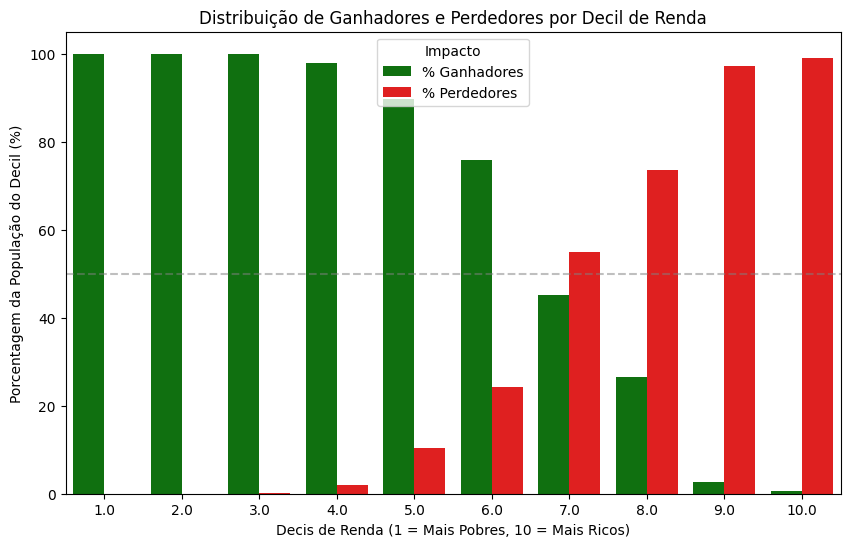

In [11]:
# (ii) Tabela de Ganhadores/Perdedores por Decil
resumo_decil = df.groupby('DECIL').apply(
    lambda x: pd.Series({
        '% Ganhadores': (x.loc[x['STATUS']=='Ganhador', 'PESO'].sum() / x['PESO'].sum()) * 100,
        '% Perdedores': (x.loc[x['STATUS']=='Perdedor', 'PESO'].sum() / x['PESO'].sum()) * 100,
        '% Neutros': (x.loc[x['STATUS']=='Neutro', 'PESO'].sum() / x['PESO'].sum()) * 100,
        'Renda Média Antes': np.average(x['RDDPC'], weights=x['PESO']),
        'Renda Média Depois': np.average(x['RDDPC_NOVA'], weights=x['PESO'])
    })
).reset_index()

print("\n(ii) RESULTADO: GANHADORES E PERDEDORES POR DECIL")
print(resumo_decil.round(1).to_string(index=False))

# Gráfico 2: Ganhadores e Perdedores
plt.figure(figsize=(10, 6))
# Derretendo o dataframe para formato longo (seaborn friendly)
df_melt = resumo_decil.melt(id_vars='DECIL', 
                            value_vars=['% Ganhadores', '% Perdedores'], 
                            var_name='Tipo', value_name='Porcentagem')

sns.barplot(data=df_melt, x='DECIL', y='Porcentagem', hue='Tipo', palette=['green', 'red'])
plt.title('Distribuição de Ganhadores e Perdedores por Decil de Renda')
plt.ylabel('Porcentagem da População do Decil (%)')
plt.xlabel('Decis de Renda (1 = Mais Pobres, 10 = Mais Ricos)')
plt.axhline(50, color='gray', linestyle='--', alpha=0.5)
plt.legend(title='Impacto')
plt.savefig('grafico_distributivo.png')
plt.show()